In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# Do smokers have higher insurance charges than non-smokers?

## Defining my Null and Alternative Hypothesis
* Null Hypothesis: There is no difference in insurance costs between smokers and non-smokers
* Alternative Hypothesis: There is a significant difference in insurance costs between smokers and non-smokers

* Significance Level (alpha): 0.05

## Test
I want to test the means of two samples. This means that the data is numeric, so we can run a 2 sample T-test. In order to run a 2 sample T-Test, we need to test the samples for significant outliers, normality, and for equal variance.

## Exploring the data and testing assumptions

In [4]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [5]:
# Separating the data into smoker and non smoker
smokers = df.loc[df['smoker'] == 'yes', 'charges'].copy()
non_smokers = df.loc[df['smoker'] == 'no', 'charges'].copy()

### Normality
Because we have over 15 samples in each group, we do not need to test for normality

### Outliers
Lets remove any outliers for each sample that have a z-score greater than 3

In [6]:
zscores_s = stats.zscore(smokers)
outliers_s = np.abs(zscores_s)>3
print(f'Outliers: {np.sum(outliers_s)}')
print(smokers.shape)

Outliers: 0
(274,)


No outliers for smokers

In [7]:
zscores_ns = stats.zscore(non_smokers)
outliers_ns = np.abs(zscores_ns)>3
print(f'Outliers: {np.sum(outliers_ns)}')
print(non_smokers.shape)

Outliers: 24
(1064,)


24 outliers for non smokers. lets remove them from the sample

In [8]:
non_smokers = non_smokers.loc[np.abs(stats.zscore(non_smokers))<=3]
non_smokers.shape

(1040,)

### Variance
Now to test for equal variance between the two groups

In [9]:
var = stats.levene(smokers, non_smokers)
var

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

The test results require us to reject the null hypothesis that the variances are equal, so we cannot assume the variance is equal in these two samples. We will have to include equal_var = False when we perform our t-test

## T-Test

In [10]:
result = stats.ttest_ind(smokers, non_smokers, equal_var = False)
result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

The p-value of the t-test is way below our significance level of 0.05, so we must reject the null hypothesis that there is no difference between insurance costs between smokers and non-smokers

## Supporting Visualization

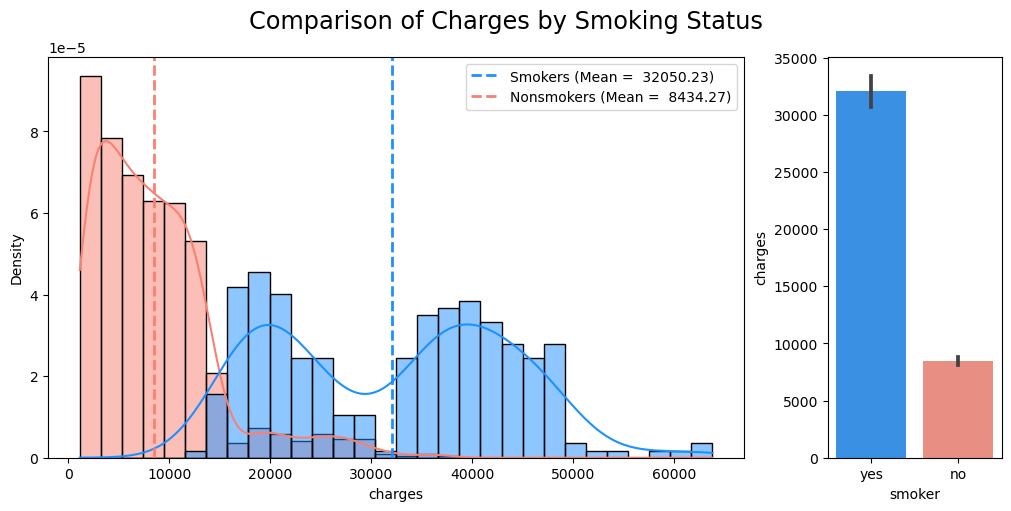

In [11]:
# Calculating means
smokers_mean = np.mean(df.loc[df['smoker'] == 'yes', 'charges'])
non_smokers_mean = np.mean(df.loc[df['smoker'] == 'no', 'charges'])

# Colors
groups_palette={'yes': 'dodgerblue', 
                "no": 'salmon'}

# Instancing the plots
fig, (ax, ax_bar) = plt.subplots(figsize = (10, 5), 
                                 ncols = 2, 
                                 constrained_layout = True,
                                 gridspec_kw = {'width_ratios': [0.8, 0.2]})

# Histogram
ax = sns.histplot(data = df, 
                  x = 'charges', 
                  fill = True, 
                  hue = 'smoker', 
                  kde = True, 
                  stat = 'density', 
                  common_norm = False,
                  ax = ax, 
                  palette = groups_palette)

ax.axvline(smokers_mean, 
           ls = '--',
           lw = 2, 
           label = f"Smokers (Mean = {smokers_mean: .2f})",
           color = groups_palette['yes'])

ax.axvline(non_smokers_mean, 
           ls = '--', 
           lw = 2, 
           label = f"Nonsmokers (Mean = {non_smokers_mean: .2f})",
           color = groups_palette['no'])

ax.legend(prop = {"size": 10}, 
          loc = 'upper right')

# Barplot
sns.barplot(data = df, 
            x = 'smoker', 
            y = 'charges',
            ax = ax_bar,
            palette = groups_palette)

fig.suptitle('Comparison of Charges by Smoking Status',
             fontsize = 'xx-large');

# Are Men more likely to smoke than Women?

## Defining my Null and Alternative Hypothesis
* Null Hypothesis: There is no difference in the likeliness to smoke between Men and Women
* Alternative Hypothesis: There is a significant difference in the likeliness to smoke between Men and Women

* Significance Level (alpha): 0.05

## Test
This is a Categorical Test on two groups, The best test to use will be a Chi Squared Test. The assumptions for a Chi Squared test are two categorical variables, and Independent Outcomes

* The outcomes of this test are independent as we can assume that mens likeliness to smoke is not influenced by womens likeliness to smoke and vice versa

## Cross Tab
First step is to create a cross tab of our data

In [12]:
tabs = pd.crosstab(df['sex'], df['smoker'])
tabs

smoker,no,yes
sex,,
female,547,115
male,517,159


## Results

In [13]:
result = stats.chi2_contingency(tabs)
chi2, p, deg_free, expected_vals = result
print(p)

0.006548143503580696


Our P-value is below our alpha of 0.05, so we must reject the null hypothesis, meaning we found a significant difference in likelihood of smoking between men and women.

## Supporting Visual

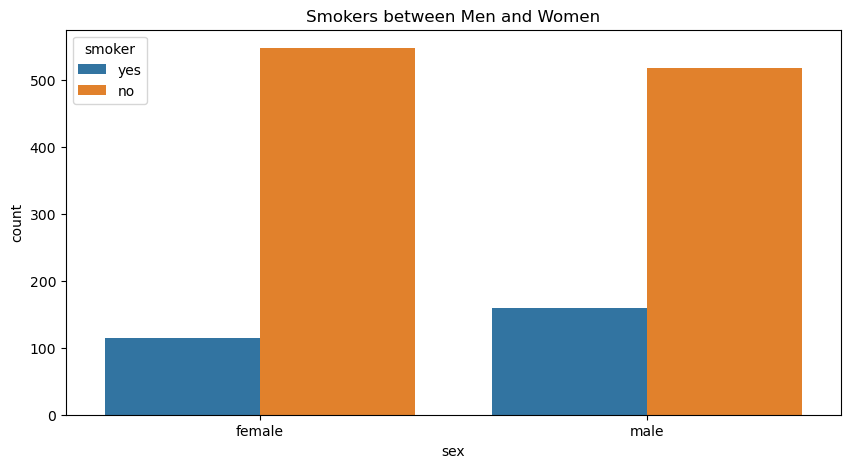

In [14]:
fig, ax = plt.subplots(figsize = (10,5))
sns.countplot(data = df, ax = ax, x = 'sex', hue = 'smoker')
ax.set_title('Smokers between Men and Women');

# Do different regions have different charges, on average?

## Defining my Null and Alternative Hypothesis
* Null hypothesis: There is no difference between regions on insurance charges
* Alternative hypothesis: There is a significant difference between regions on insurance charges
* Significance Level (alpha): 0.05

In [15]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

## Test
We will be testing charges, which is numeric and nominal data. We will test the mean against the 4 different regions found in the dataset. We will run an ANOVA test, and a Tukey test if we find statistical significance. In order to run an ANOVA, we need to prove the following assumptions:
* No significant Outliers
* Equal Variance
* Normality

## Grouping the data into dictionaries
Before I begin analyzing the data, I want to put the data into a dictionary

In [16]:
groups = {}

# Looping through the groups in the dataframe
for i in df['region'].unique():
    # Creating a copy of the column for each region
    data = df.loc[df['region'] == i, 'charges'].copy()
    
    # Saving into the dictionary on the correct key
    groups[i] = data
    
groups

{'southwest': 0       16884.92400
 12       1826.84300
 15       1837.23700
 18      10602.38500
 19      36837.46700
            ...     
 1316     1731.67700
 1329    10325.20600
 1331    10795.93733
 1332    11411.68500
 1336     2007.94500
 Name: charges, Length: 325, dtype: float64,
 'southeast': 1        1725.5523
 2        4449.4620
 5        3756.6216
 6        8240.5896
 11      27808.7251
            ...    
 1322    12981.3457
 1323    43896.3763
 1327     9377.9047
 1330    12629.1656
 1335     1629.8335
 Name: charges, Length: 364, dtype: float64,
 'northwest': 3       21984.47061
 4        3866.85520
 7        7281.50560
 9       28923.13692
 24       6203.90175
            ...     
 1319     7201.70085
 1320     5425.02335
 1324     4239.89265
 1333    10600.54830
 1337    29141.36030
 Name: charges, Length: 325, dtype: float64,
 'northeast': 8        6406.41070
 10       2721.32080
 16      10797.33620
 17       2395.17155
 20      13228.84695
            ...     
 1321

### Normality
Because our samples are each above n = 15, we do not need to test for normality

### Outliers
Lets check each group for outliers and remove them

In [17]:
for i, charges in groups.items():
    zscores = stats.zscore(charges)
    outliers = np.abs(zscores) > 3
    print(f'Outliers in {i}: {np.sum(outliers)}')
    print(f'Original Length: {len(charges)}')

Outliers in southwest: 8
Original Length: 325
Outliers in southeast: 2
Original Length: 364
Outliers in northwest: 7
Original Length: 325
Outliers in northeast: 4
Original Length: 324


We show that there are significant outliers in each group. Lets remove them from the dictionary and proceed with our next test

In [18]:
for i, charges in groups.items():
    groups[i] = charges[np.abs(stats.zscore(charges)) <= 3]
    print(f'Final Length of {i}: {len(groups[i])}')

Final Length of southwest: 317
Final Length of southeast: 362
Final Length of northwest: 318
Final Length of northeast: 320


### Variance

In [19]:
var = stats.levene(*groups.values())
var

LeveneResult(statistic=9.518349004554441, pvalue=3.2035503711783993e-06)

the variance test is below 0.05, meaning we must reject the null hypothesis, and we have found statistical significance between the variance of our groups. We must change tests and use Kruskal Wallis

## Changing tests to Kruskal Wallis

In [20]:
result = stats.kruskal(*groups.values())
result

KruskalResult(statistic=6.914045702545643, pvalue=0.07468847911322242)

The Kruskal Wallis test returned a p-value greater than our significance level, meaning we must accept the null hypothesis that there is no significant difference in charges between regions

## Supporting Visual

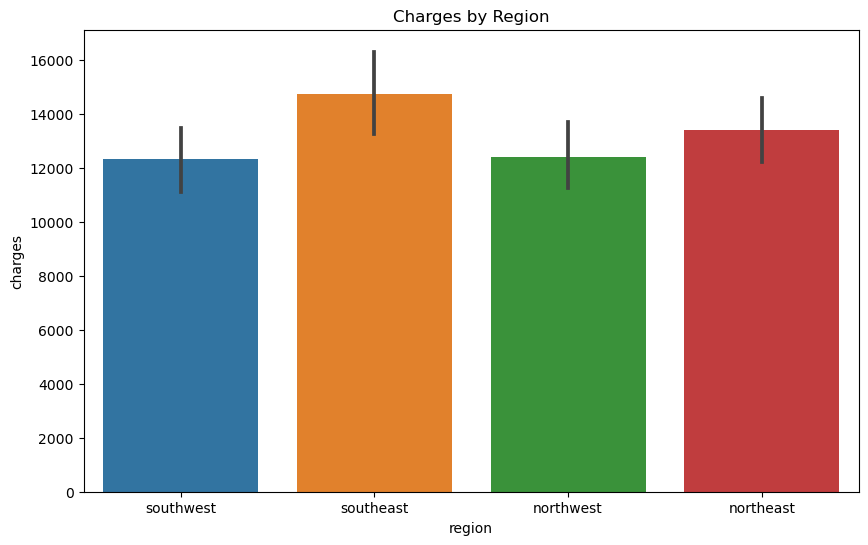

In [25]:
fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(data = df, x = 'region', y = 'charges', ax = ax)
ax.set_title('Charges by Region');